In [1]:
import cohere
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import umap
# import umap.plot

cohere_key = "KDASoDyU8wg92gBTjyAOk2bRMhPq8A0oh3ea24m6"

In [53]:
topic = "politics"
countries = "Afghan,American,Bangladeshi,British,Canadian,Chinese,French,German,Indian,Japanese,Mexican,Pakistani,South African".split(
    ","
)
type = "top"
num_words = 15

model = "gpt_3-5_20240328"  # @param ["gpt_3-5_20240223-0310", "hand_curated_large/results/100_tokens/llama2_13B_chat_quantized"] {type:"string"}
level = "overall"  # @param ["topicwise", "overall"] {type:"string"}
method = "tfidf"  # @param ["kld", "tfidf"] {type:"string"}

path = f"/home/shailyjb/pref_cult/creative_prompts/results/{model}/word_distributions_{level}_{method}.tsv"

In [54]:
with open(path) as f:
    lines = f.readlines()
data = [line.strip().split("\t") for line in lines]
data = [line for line in data if line]
if level == "topicwise":
    data = [line[1:] for line in data if line[0] == topic]
data = [line for line in data if line[0] in countries]
data = [line for line in data if line[1] == type]
# print(len(data))
words = {}
for line in data:
    country = line[0]
    words[country] = []
    line = line[2:]
    for i in range(0, len(line), 2):
        word = line[i]
        words[country].append(word)
    words[country] = words[country][:num_words] if num_words < len(words[country]) else words[country]        

In [55]:
print(words.keys())

dict_keys(['Afghan', 'American', 'Bangladeshi', 'British', 'Canadian', 'Chinese', 'French', 'German', 'Indian', 'Japanese', 'Mexican', 'Pakistani', 'South African'])


In [56]:
co = cohere.Client(cohere_key)

In [57]:
trial_word = words["American"][0]
word_embedding = co.embed(
    texts=[trial_word], input_type="clustering", model="embed-multilingual-v3.0"
).embeddings
word_embedding = np.asarray(word_embedding)
word_embedding.shape

(1, 1024)

In [58]:
embedded_words = {}
for country in words:
    embeddings = co.embed(texts=words[country], input_type="clustering", model="embed-multilingual-v3.0").embeddings
    embeddings = np.asarray(embeddings)
    print(embeddings.shape)
    embedded_words[country] = embeddings

(15, 1024)
(15, 1024)
(15, 1024)
(15, 1024)
(15, 1024)
(15, 1024)
(15, 1024)
(15, 1024)
(15, 1024)
(15, 1024)
(15, 1024)
(15, 1024)
(15, 1024)


In [59]:
tsne_model = TSNE(
    n_components=2, init="pca", random_state=0, perplexity=30, n_iter=5000
)

In [60]:
print(embedded_words.keys())
print(words.keys())

dict_keys(['Afghan', 'American', 'Bangladeshi', 'British', 'Canadian', 'Chinese', 'French', 'German', 'Indian', 'Japanese', 'Mexican', 'Pakistani', 'South African'])
dict_keys(['Afghan', 'American', 'Bangladeshi', 'British', 'Canadian', 'Chinese', 'French', 'German', 'Indian', 'Japanese', 'Mexican', 'Pakistani', 'South African'])


In [61]:
all_embeddings = np.concatenate(
    [embedded_words[country] for country in embedded_words.keys()], axis=0
)
country_labels = np.concatenate([[country] * 15 for country in embedded_words.keys()])
word_labels = np.concatenate(
    [words[country] for country in embedded_words.keys()]
)
print(len(word_labels))

195


In [62]:
embeddings_2d = tsne_model.fit_transform(all_embeddings)

In [63]:
print(embeddings_2d.shape)

(195, 2)


In [64]:
tsne_reduced = {}
for country, word, embedding_2d in zip(country_labels, word_labels, embeddings_2d):
    if country not in tsne_reduced:
        tsne_reduced[country] = []
    tsne_reduced[country].append((word, embedding_2d))
print(tsne_reduced)
print(len(tsne_reduced.keys()))


{'Afghan': [('amir', array([-1.8566806,  6.879276 ], dtype=float32)), ('ali', array([-6.1941648,  6.576901 ], dtype=float32)), ('afghanistan', array([14.338933 , -0.5191864], dtype=float32)), ('ahmad', array([-2.1754436,  5.1692953], dtype=float32)), ('zahra', array([ 2.4495585, 14.31501  ], dtype=float32)), ('amina', array([-0.420865 ,  2.0532296], dtype=float32)), ('rostam', array([  8.244425, -11.937989], dtype=float32)), ('babar', array([-9.137562, 14.521048], dtype=float32)), ('sara', array([ 1.3542111, 12.053178 ], dtype=float32)), ('omar', array([-2.719567 ,  7.5743423], dtype=float32)), ('cally', array([3.2828748, 2.660799 ], dtype=float32)), ('farid', array([-15.713142,  -7.514139], dtype=float32)), ('afghan', array([14.359704  , -0.12910159], dtype=float32)), ('treehouse', array([  4.1555758, -13.023933 ], dtype=float32)), ('bari', array([-6.760524, 12.726401], dtype=float32))], 'American': [('tommy', array([ 0.46755338, -0.14250754], dtype=float32)), ('lily', array([4.710892

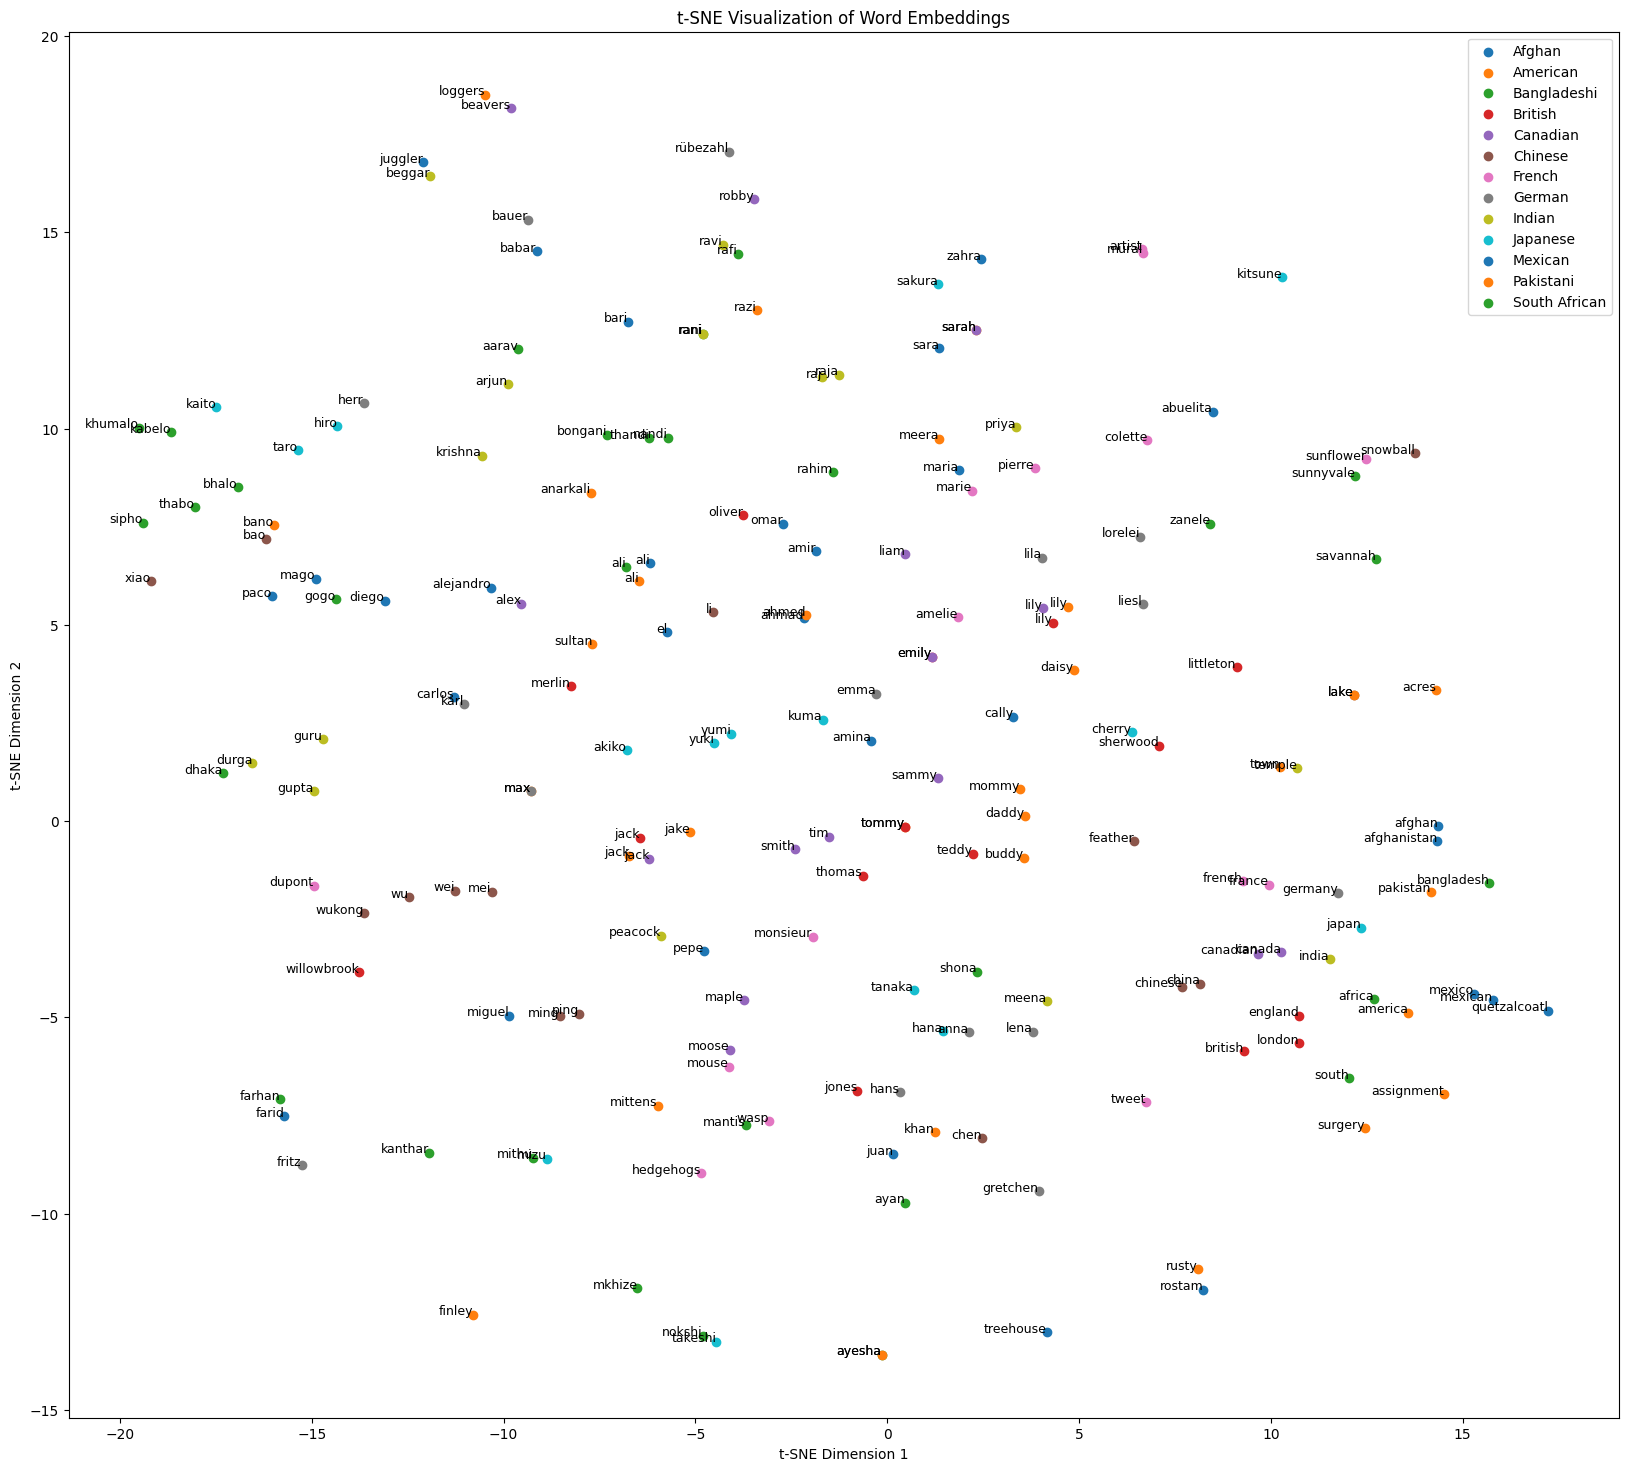

In [65]:
# Plot a scatter plot with the 2 dimensional t-SNE embeddings with one color per country and word labels on the plot
# plt.figure(figsize=(16, 10))
# for country, embeddings in tsne_reduced.items():
#     for (word, (x, y)) in embeddings:
#         plt.scatter(x, y, label=country, s=100)
#         plt.text(x, y, word, fontsize=9)
# plt.legend()
# plt.show()

plt.figure(figsize=(20,18))
for country in tsne_reduced.keys():
    word_and_emddings_array = tsne_reduced[country]
    words_array = [word for word, _ in word_and_emddings_array]
    embeddings_array = [embedding for _, embedding in word_and_emddings_array]
    embeddings_array = np.array(embeddings_array)
    plt.scatter(embeddings_array[:, 0], embeddings_array[:, 1], label=country)
    for i, word in enumerate(words_array):
        plt.text(embeddings_array[i, 0], embeddings_array[i, 1], word, fontsize=9, ha='right')
plt.legend()
plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()